In [1]:
import nibabel as nib
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import robustReebConstruction as rc
import os
import pickle
from mpl_toolkits.mplot3d import Axes3D
def graph_vis(G, node_loc, streamlines):
    # 3d spring layout
    pos = node_loc
    # Extract node and edge positions from the layout
    node_xyz = np.array([pos[v] for v in sorted(G)])
    edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

    # Create the 3D figure
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(111, projection="3d")

    # Plot the nodes - alpha is scaled by "depth" automatically
    ax.scatter(*node_xyz.T, s=100, ec="w",label = None)
    for i in range(len(streamlines)):
        xdata = []
        ydata = []
        zdata = []
        for j in streamlines[i]:
            xdata.append(j[0])
            ydata.append(j[1])
            zdata.append(j[2])
        ax.plot3D(xdata,ydata,zdata,color= '#bfbfbf', lw = 2);
    # Plot the nodes
    ax.scatter(*node_xyz.T, s=400, ec="w", color = 'r', zorder=100)
    edge_labels = nx.get_edge_attributes(G, "weight")
    # Plot the edges
    weight_labels = list(edge_labels.values())
    count = 0
    for vizedge in edge_xyz:
        wt = weight_labels[count]*5
        if wt == 10:
            ax.plot(*vizedge.T, color='g',
                    lw = wt,
                    zorder = 50,
                   label = str(weight_labels[count]))
        else:
            ax.plot(*vizedge.T, color='#000000',
                    lw = wt,
                    zorder = 50,
                   label = str(weight_labels[count]))
        count+=1


    def _format_axes(ax):
        """Visualization options for the 3D axes."""
        # Turn gridlines off
        ax.grid(False)
        # Suppress tick labels
        for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
            dim.set_ticks([])
        # Set axes labels
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")


    _format_axes(ax)
    fig.tight_layout()
    plt.axis("off")
    plt.legend()

In [2]:
%%time
import siminetInsertDelCost as sn
from functools import partial

def annotate_graph(graph, node_positions):
    for e in graph.edges:
        n1, n2 = e
        pos1, pos2 = np.array(node_positions[n1]), np.array(node_positions[n2])
        graph.nodes[n1]["position"] = pos1
        graph.nodes[n2]["position"] = pos2
        graph.edges[e]["distance"] = np.linalg.norm(pos1 - pos2)
        
def merge_equivalent(graph, node_annotations):
    """
    Intakes a graph and its associated node annotations where some nodes may have the same annotation (spatial position). 
    Those equivalent nodes will be merged into the same node, and edges involving these equivalent nodes will be inherited 
    by the final node.
    """
    
    equivalences = dict()
    
    for pos, node in node_annotations.items():
        if pos not in equivalences:
            equivalences[pos] = []
        
        equivalences[pos].append(node)
        
    for eq_group in equivalences.values():
        if len(eq_group) == 1: # nothing to merge
            continue
            
        head, tail = eq_group[0], eq_group[1:]
        for n in tail:
            nx.contracted_nodes(graph, head, n, copy=False)

CPU times: user 0 ns, sys: 36.5 ms, total: 36.5 ms
Wall time: 2.67 ms


In [3]:
sub_list = ['4936m', '1808u', '1142k', '2027j', '4917f', '4961a']

#my_scoring_fn gives the flexibility of deciding on which distance score do you want to use.
#Here, we use normalized node_score as ur scoring functin to quantify topological difference between the bundle tracts.
def my_scoring_fn(node_score, edge_weight_score, edge_dist_score, gcmp, gref, eps, alpha, delta):
    return node_score/len(gref.nodes())
eps =2.5
alpha = 3
delta = 5
dist_hm = []
del_list = []
inter_dist = []
intra_dist = []
for subi in range(len(sub_list)):
    for i in range(1,10):
            dist_sub = []
            for subj in range(len(sub_list)):
                for j in range(1,10): 
                    try:                        
                        H1 =nx.read_gpickle("ReebGraphsCRASH/H_CC_sub-"+str(sub_list[subi])+"_ses-"+str(i)+".gpickle")
                        with open("ReebGraphsCRASH/node_loc_CCsub-"+str(sub_list[subi])+"_ses-"+str(i)+".pickle", 'rb') as handle:
                            node_loc_all = pickle.load(handle)
                        merge_equivalent(H1, node_loc_all)
                        annotate_graph(H1, node_loc_all)
                        node_list = H1.nodes()
                        node_loc = {}
                        for node_key in node_loc_all.keys():
                            if node_key in node_list:
                                node_loc[node_key] = node_loc_all[node_key]
                        x_c1 = sum([list(node_loc.values())[idx][0] for idx in range(len(node_loc.values()))])/len(node_loc.values())
                        y_c1 = sum([list(node_loc.values())[idx][1] for idx in range(len(node_loc.values()))])/len(node_loc.values())
                        z_c1 = sum([list(node_loc.values())[idx][2] for idx in range(len(node_loc.values()))])/len(node_loc.values())

                        H2 =nx.read_gpickle("ReebGraphsCRASH/H_CC_sub-"+str(sub_list[subj])+"_ses-"+str(j)+".gpickle")
                        with open("ReebGraphsCRASH/node_loc_CCsub-"+str(sub_list[subj])+"_ses-"+str(j)+".pickle", 'rb') as handle:
                            node_loc_all = pickle.load(handle)
                        merge_equivalent(H2, node_loc_all)
                        annotate_graph(H2, node_loc_all)
                        node_list = H2.nodes()
                        node_loc = {}
                        for node_key in node_loc_all.keys():
                            if node_key in node_list:
                                node_loc[node_key] = node_loc_all[node_key]
                        x_c2 = sum([list(node_loc.values())[idx][0] for idx in range(len(node_loc.values()))])/len(node_loc.values())
                        y_c2 = sum([list(node_loc.values())[idx][1] for idx in range(len(node_loc.values()))])/len(node_loc.values())
                        z_c2 = sum([list(node_loc.values())[idx][2] for idx in range(len(node_loc.values()))])/len(node_loc.values())

                        sub_r = np.linalg.norm(np.array([x_c1,y_c1,z_c1]) - np.array([x_c2,y_c2,z_c2]))
                        dist = partial(sn.distance, eps=eps, alpha=alpha, delta=delta, scoring_func=my_scoring_fn,ins_cost = 2*eps*(1+sub_r/30))
                        dist = 0.5*(dist(H1, H2) + dist(H2, H1))

                        if dist>20:
                            dist_sub.append(20)
                        else:
                            dist_sub.append(dist)

                        if (subj == subi):
                            intra_dist.append(dist)
                        else:
                            inter_dist.append(dist)
                    except:
                        pass #session numbers are different, so to pass the sesson numbers not present
#                         print(subi,subj,i,j)
            dist_hm.append(dist_sub)

Text(0.5, 1.0, 'CC')

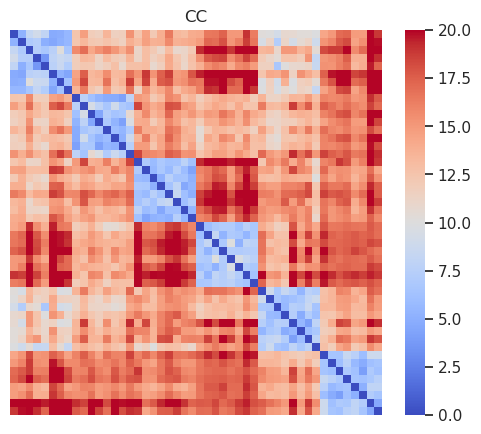

In [4]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(6,5)})
dist = [i for i in dist_hm if len(i)==48
       ]
ax = sns.heatmap(dist,cmap = "coolwarm",yticklabels=False,xticklabels=False)
plt.title("CC")

# Statistical analysis of topological distance as a feature to distinguish between bundles of different subjects
The statistical significance of the difference between inter- and intra- distances based on these tractometry metrics is negligible $(p \sim .99)$ for tractometry methods while the differences between the inter- and intra- distances are statistically significant with p $\sim$ 0 for the proposed Reeb graph-based distances.

In [5]:
#pvalue ~ 0 indicates the significance of topological distance as a featureto disntinguish between bundles of different subjects.
import scipy.stats as stats
stats.ttest_ind(a=inter_dist,b=intra_dist,equal_var=False)

Ttest_indResult(statistic=65.27468260808237, pvalue=1.8562400326400635e-279)